In [1]:
#imports personal details to connect to db
import config
#import our function files
import query_helper
import payscale_uni_webscrape


import json
import requests
from bs4 import BeautifulSoup
api_key = config.API_key
import time 
import mysql.connector
from mysql.connector import errorcode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics
import math
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.power import TTestIndPower

# Below 2 cells creates database

In [2]:
# db_name = 'colleges'
# ## Connect to DB server on AWS
# ## connecting to the database using 'connect()' method
# ## it takes 3 required parameters 'host', 'user', 'passwd'
# cnx = mysql.connector.connect(
#     host = config.host,
#     user = config.user,
#     passwd = config.password,
#     database = "colleges"       #can say what database we expect everything loaded into
# )
# cursor = cnx.cursor()

In [3]:
# def create_database(cursor, database):
#     try:
#         cursor.execute(
#             "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
#     except mysql.connector.Error as err:
#         print("Failed creating database: {}".format(err))
#         exit(1)

# try:
#     cursor.execute("USE {}".format(db_name))
# except mysql.connector.Error as err:
#     print("Database {} does not exists.".format(db_name))
#     if err.errno == errorcode.ER_BAD_DB_ERROR:
#         create_database(cursor, db_name)
#         print("Database {} created successfully.".format(db_name))
#         cnx.database = db_name
#     else:
#         print(err)
#         exit(1)

In [4]:
query ='''
SELECT 
    *
FROM 
    payscale_colleges
INNER JOIN college_info 
    ON college = uni;
    '''
df_joined = query_helper.query_to_df(query)
df_joined.shape

(1086, 24)

In [5]:
query ='''
SELECT 
    *
FROM 
    college_info
OUTTER JOIN payscale_colleges 
    ON college = uni;
    '''
df_outter = query_helper.query_to_df(query)
df_outter.shape

(1086, 24)

In [ ]:
db_name = 'colleges'
## Connect to DB server on AWS
## connecting to the database using 'connect()' method
## it takes 3 required parameters 'host', 'user', 'passwd'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = "colleges"       #can say what database we expect everything loaded into
)
cursor = cnx.cursor()

In [ ]:
def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

In [7]:
#write a query entry to creat a table
payscale_colleges = """
CREATE TABLE payscale_colleges (
      uni varchar(100) PRIMARY KEY,
      uni_type varchar(100),
      early_car_pay int,
      mid_car_pay int,
      high_meaning float,
      stem_deg float
    );
"""

In [8]:
query_helper.create_table(payscale_colleges)

Creating a new table
already exists.


In [3]:
#Below code gets info for page then commits to db, repeats process on all pages
#if we have duplicates they will be skipped on db commit process

web_page_iterator = 1
while web_page_iterator <64:
    #scrape web infor for 1 page
    list_of_dict = payscale_uni_webscrape.get_pages(web_page_iterator)

    #put infor into tuples and commit to db
    query_helper.tuple_payscale_uni(list_of_dict)
    
    #iterate and loop
    web_page_iterator +=1
    


KeyboardInterrupt: 

In [4]:
df = query_helper.query_to_df('SELECT * FROM payscale_colleges')

In [5]:
# df[df['early_car_pay']]
df_private = df[df.uni_type.str.contains('Private')==True]

In [6]:
df['Private'] = 0
df.head()


,uni,uni_type,early_car_pay,mid_car_pay,high_meaning,stem_deg,Private
0,Abilene Christian University,"Private School, Religious, For Sports Fans",49700,90900,53.0,9.0,0
1,Adams State University,State School,44400,81400,56.0,3.0,0
2,Adelphi University,"Private School, Research University",53700,96400,50.0,6.0,0
3,Adrian College,"Private School, Religious",42400,78000,58.0,12.0,0
4,Adventist University of Health Sciences,"Private School, Religious",51600,89800,88.0,5.0,0


In [7]:
df["Private"] = df.uni_type.apply(lambda x: 1 if "Private" in x else 0)

In [8]:
df.head()

,uni,uni_type,early_car_pay,mid_car_pay,high_meaning,stem_deg,Private
0,Abilene Christian University,"Private School, Religious, For Sports Fans",49700,90900,53.0,9.0,1
1,Adams State University,State School,44400,81400,56.0,3.0,0
2,Adelphi University,"Private School, Research University",53700,96400,50.0,6.0,1
3,Adrian College,"Private School, Religious",42400,78000,58.0,12.0,1
4,Adventist University of Health Sciences,"Private School, Religious",51600,89800,88.0,5.0,1


In [9]:
df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()

                      Private
early_car_pay  count  0            580.000000
                      1            985.000000
               mean   0          49548.275862
                      1          48995.329949
               std    0           6900.890818
                      1           8315.776130
mid_car_pay    count  0            580.000000
                      1            985.000000
               mean   0          89155.344828
                      1          88395.837563
               std    0          13135.943480
                      1          15714.752563
dtype: float64

In [10]:
df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()

                      Private
early_car_pay  count  0            580.000000
                      1            985.000000
               mean   0          49548.275862
                      1          48995.329949
               std    0           6900.890818
                      1           8315.776130
mid_car_pay    count  0            580.000000
                      1            985.000000
               mean   0          89155.344828
                      1          88395.837563
               std    0          13135.943480
                      1          15714.752563
dtype: float64

In [11]:
public_early_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[0]
private_early_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[1]
public_early_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[2]
private_early_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[3]
public_early_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[4]
private_early_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[5]

# get mid career info
public_mid_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[6]
private_mid_count = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[7]
public_mid_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[8]
private_mid_mean = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[9]
public_mid_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[10]
private_mid_std = df.groupby(['Private'])[['early_car_pay','mid_car_pay']].agg(['count', 'mean',np.std]).unstack()[11]


In [12]:
print(public_early_count)
print(private_early_count)
print(public_early_mean)
print(private_early_mean)
print(public_early_std)
print(private_early_std)

print(public_mid_count)
print(private_mid_count) 
print(public_mid_mean)
print(private_mid_mean)
print(public_mid_std)
print(private_mid_std)

580.0
985.0
49548.275862068964
48995.32994923858
6900.890818301473
8315.776129743184
580.0
985.0
89155.3448275862
88395.83756345177
13135.94347990051
15714.75256259765


In [13]:
df_private = df[df['Private']==1]
df_public = df[df["Private"]==0]

In [14]:
private=df_private['early_car_pay']
private_list = private.tolist()
private.describe()

public=df_public['early_car_pay']
public_list = public.tolist()
public.describe()

count      580.000000
mean     49548.275862
std       6900.890818
min      32500.000000
25%      44775.000000
50%      48650.000000
75%      52700.000000
max      80600.000000
Name: early_car_pay, dtype: float64

In [15]:
# mu_private = private.mean()
# sigma_private = private.std()

# mu_private, sigma_private

In [16]:
# ambient_pressure = df['AP'].values
# standardized_ambient_pressure = (ambient_pressure - mu)/sigma

[]

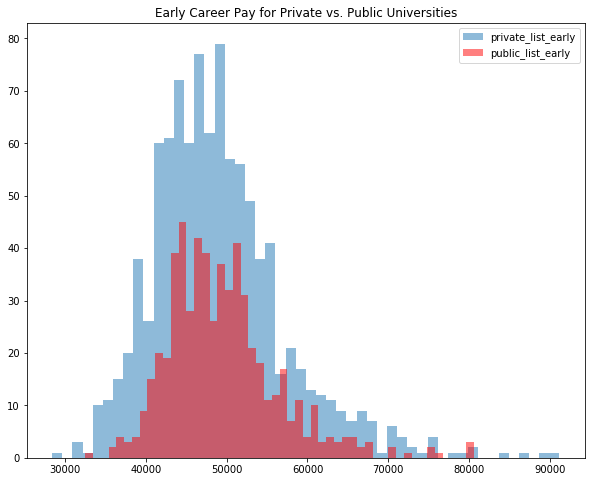

In [17]:
plt.figure(figsize=(10,8))
plt.hist(private_list, bins=50, alpha=.5,label ='private_list_early')
plt.hist(public_list, bins=50, color='r', alpha = 0.5, label='public_list_early')
plt.legend()
plt.title('Early Career Pay for Private vs. Public Universities')
plt.plot()

/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[]

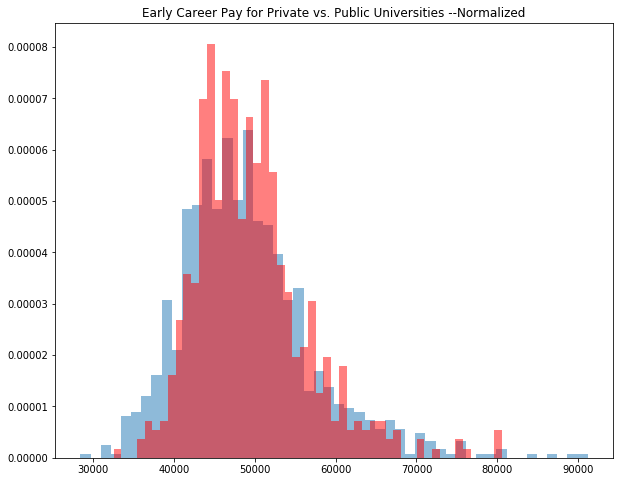

In [18]:
plt.figure(figsize=(10,8))
plt.hist(private_list, bins=50, alpha=.5, normed=True)
plt.hist(public_list, bins=50, color='r', alpha = 0.5, normed=True)
plt.title('Early Career Pay for Private vs. Public Universities --Normalized')
plt.plot()

## Sample using Central limit theorem to get normal distribution

Mean: 48992.96779, Standard Deviation: 788.2993447241446
Mean: 49543.13323, Standard Deviation: 626.3545414378084


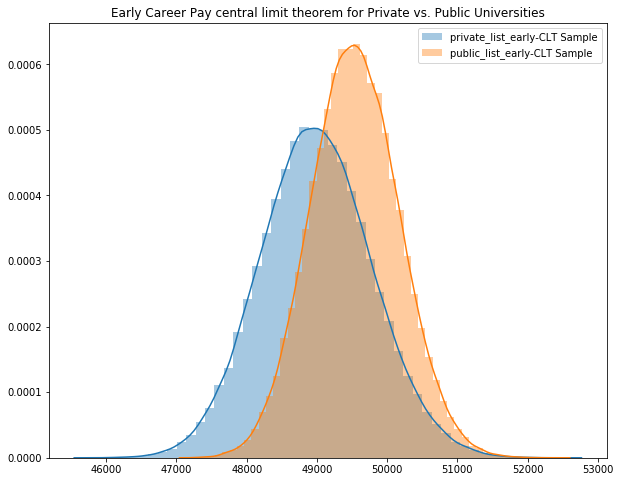

In [19]:
samples = [np.random.choice(private_list, replace=False, size=100) for i in range(100000)]
print('Mean: {}, Standard Deviation: {}'.format(
                                                np.mean([np.mean(i) for i in samples]),
                                                np.std([np.mean(i) for i in samples])
                                            )
     )

samples1 = [np.random.choice(public_list, replace=False, size=100) for i in range(100000)]
print('Mean: {}, Standard Deviation: {}'.format(
                                                np.mean([np.mean(i) for i in samples1]),
                                                np.std([np.mean(i) for i in samples1])
                                            )
     )
plt.figure(figsize=(10,8))
sns.distplot([np.mean(i) for i in samples],label ='private_list_early-CLT Sample')
sns.distplot([np.mean(i) for i in samples1],label ='public_list_early-CLT Sample')
plt.title('Early Career Pay central limit theorem for Private vs. Public Universities')
plt.legend()

## One-sample z-tests!

Recall the test statistic for a one-sample z-test is the z-statistic: 

$$ \large \text{z-statistic} = \dfrac{\bar x - \mu_0}{{\sigma}/{\sqrt{n}}} $$

* $\bar x$ is your sample mean
* $n$ is the number of items in your sample 
* $\sigma$ is the population standard deviation
* $\mu_0$ is the population mean

The z-statistic differs from the standard score formula: we divide the standard deviation by the square root of $n$ to reflect that we are dealing with the _sample variance_. 

## Now well do a 2 sample z test for EARLY CAREER SALARY


In [20]:
standard_error_of_mean_diff = math.sqrt((public_early_std**2/public_early_count +private_early_std**2/private_early_count))
z = (public_early_mean-private_early_mean)/(standard_error_of_mean_diff)
z

1.4168201211290246

We fail to reject our null hypothesis

There is no significant difference in early career expected salary for those who attend public vs private school 

I could have made a type 2 error

## Now well do power analysis

In [21]:
p_value = stats.norm.sf(abs(z)) #one-sided
p_value

0.07826776266232675

In [22]:
beta = 1-p_value
beta

0.9217322373376733

It appears there is and 8% chance we made a Type 2 error


In [23]:
# # solve for power
# power_analysis = TTestIndPower()
# # calculate the power
# power = power_analysis.solve_power(effect_size=0.5, nobs1=500, alpha=.05)
# print("power is" + " " + str(power))
# #Calculate sample size required
# sample_size = power_analysis.solve_power(effect_size=.2, alpha=.05, power=.8)
# print("number of observation required is" + " "+ str(sample_size))

## Now well look at MID CAREER SALARY for private vs public schools

First we wil look at a histogram of mid career pay

In [24]:
private=df_private['mid_car_pay']
private_list_mid = private.tolist()
private.describe()

public=df_public['mid_car_pay']
public_list_mid = public.tolist()
public.describe()

count       580.000000
mean      89155.344828
std       13135.943480
min       61900.000000
25%       79900.000000
50%       87200.000000
75%       96025.000000
max      152800.000000
Name: mid_car_pay, dtype: float64

/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[]

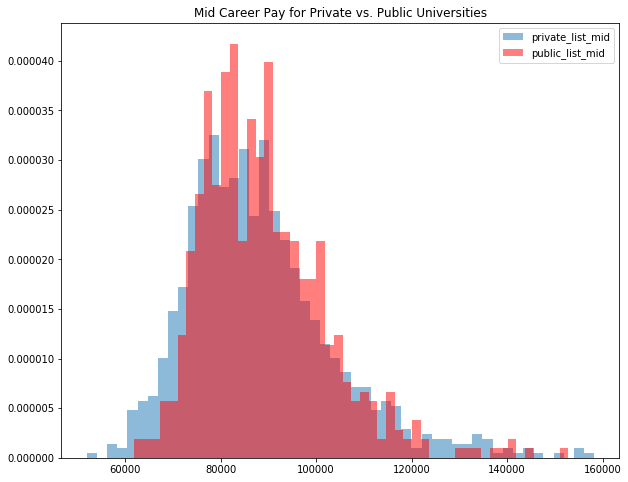

In [25]:
plt.figure(figsize=(10,8))
plt.hist(private_list_mid, bins=50, alpha=.5, normed=True, label='private_list_mid')
plt.hist(public_list_mid, bins=50, color='r', alpha = 0.5, normed=True, label="public_list_mid")
plt.legend()
plt.title('Mid Career Pay for Private vs. Public Universities')
plt.plot()

Now we'll use the central limit theorem
THis allows us to...? get sample standard deviation? 

Mean: 88398.65863, Standard Deviation: 1488.9231575392073
Mean: 89153.54145, Standard Deviation: 1197.0185282116136


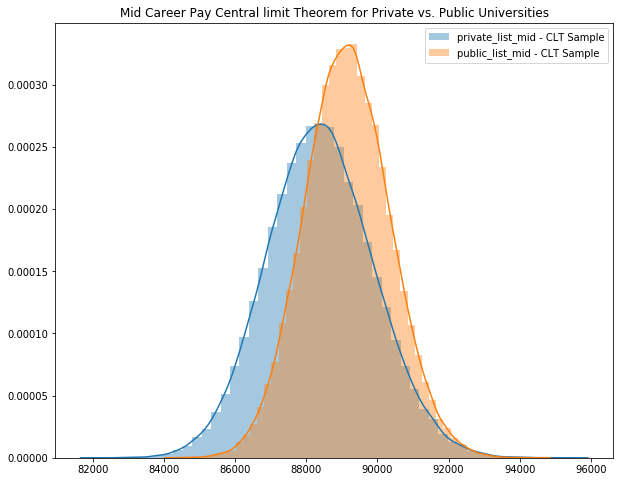

In [26]:
samples = [np.random.choice(private_list_mid, replace=False, size=100) for i in range(100000)]
print('Mean: {}, Standard Deviation: {}'.format(
                                                np.mean([np.mean(i) for i in samples]),
                                                np.std([np.mean(i) for i in samples])
                                            )
     )

samples1 = [np.random.choice(public_list_mid, replace=False, size=100) for i in range(100000)]
print('Mean: {}, Standard Deviation: {}'.format(
                                                np.mean([np.mean(i) for i in samples1]),
                                                np.std([np.mean(i) for i in samples1])
                                            )
     )
plt.figure(figsize=(10,8))
sns.distplot([np.mean(i) for i in samples],label="private_list_mid - CLT Sample")
sns.distplot([np.mean(i) for i in samples1], label= 'public_list_mid - CLT Sample')
plt.title('Mid Career Pay Central limit Theorem for Private vs. Public Universities')
plt.legend()


## Now well do a 2 sample z test MID CAREER PAY


In [38]:
standard_error_of_mean_diff = math.sqrt((public_mid_std**2/public_mid_count +private_mid_std**2/private_mid_count))
z = (public_mid_mean-private_mid_mean)/(standard_error_of_mean_diff)
z

1.0257812369620891

In [39]:
p_value = stats.norm.sf(abs(z)) #one-sided
p_value

0.15249735608732057

We fail to reject our null hypothesis

There is no significant difference in early career expected salary for those who attend public vs private school 

I could have made a type 2 error. Below well use power analysis to find the chance that a type 2 error is made

## Now well do power analysis MID CAREER PAY

In [40]:
beta = 1-p_value
beta

0.8475026439126794

There is a 16% chance we made Type 2 errors

In [41]:
df.head()

,uni,uni_type,early_car_pay,mid_car_pay,high_meaning,stem_deg,Private
0,Abilene Christian University,"Private School, Religious, For Sports Fans",49700,90900,53.0,9.0,1
1,Adams State University,State School,44400,81400,56.0,3.0,0
2,Adelphi University,"Private School, Research University",53700,96400,50.0,6.0,1
3,Adrian College,"Private School, Religious",42400,78000,58.0,12.0,1
4,Adventist University of Health Sciences,"Private School, Religious",51600,89800,88.0,5.0,1


In [61]:
corr = df.filter(['early_car_pay','mid_car_pay','high_meaning','stem_deg'],axis=1)
corr = corr.corr()
corr.columns
col=['early_car_pay', 'mid_car_pay', 'high_meaning', 'stem_deg']

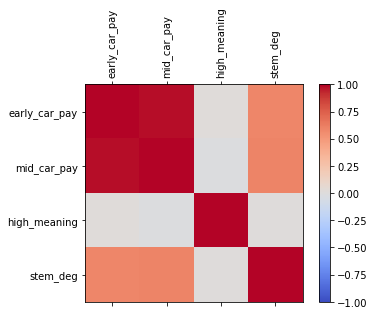

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
plt.show()